# Introduction
This part of the repository scrapes the data regarding interiors from Dezeen.com

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/dezeenAI /mydrive
!ls /mydrive

ln: failed to create symbolic link '/mydrive/dezeenAI': File exists
classes.gsheet	       dezeen_2-download.ipynb	files
darknet		       dezeen_3-dataset.ipynb	LICENSE
data		       dezeen_4-model.ipynb	OIDv4_ToolKit
dezeen_0-test.ipynb    dezeen_5-database.ipynb	README.md
dezeen_1-scrape.ipynb  dezeenAI


In [ ]:
%cd /mydrive

/content/gdrive/My Drive/Colab Notebooks/dezeenAI


## Libraries & functions
- `requests` - http handling
- `BeautifulSoup` - html parsing & web-scraping
- `urllib.request` - url-opening
- `tqdm` - loop progress bar
- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `sys` - system-specific parameters & functions

In [ ]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import timeit
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Database

## List of results
Let's get a list of results of the object detection from the previous notebook.

In [ ]:
results = [] 
DIR = '/mydrive/files/tmp/'
os.chdir(DIR)

for filename in os.listdir(os.getcwd()):
  if filename.endswith('.json'):
    results.append(DIR + filename)

results

['/mydrive/files/tmp/dezeen_results-0.json',
 '/mydrive/files/tmp/dezeen_results-1.json',
 '/mydrive/files/tmp/dezeen_results-2.json',
 '/mydrive/files/tmp/dezeen_results-3.json',
 '/mydrive/files/tmp/dezeen_results-4.json',
 '/mydrive/files/tmp/dezeen_results-5.json',
 '/mydrive/files/tmp/dezeen_results-6.json',
 '/mydrive/files/tmp/dezeen_results-7.json',
 '/mydrive/files/tmp/dezeen_results-8.json',
 '/mydrive/files/tmp/dezeen_results-9.json',
 '/mydrive/files/tmp/dezeen_results-10.json',
 '/mydrive/files/tmp/dezeen_results-11.json',
 '/mydrive/files/tmp/dezeen_results-12.json',
 '/mydrive/files/tmp/dezeen_results-13.json',
 '/mydrive/files/tmp/dezeen_results-14.json',
 '/mydrive/files/tmp/dezeen_results-15.json',
 '/mydrive/files/tmp/dezeen_results-16.json',
 '/mydrive/files/tmp/dezeen_results-17.json',
 '/mydrive/files/tmp/dezeen_results-18.json',
 '/mydrive/files/tmp/dezeen_results-20.json',
 '/mydrive/files/tmp/dezeen_results-23.json',
 '/mydrive/files/tmp/dezeen_results-22.json'

## Concatenate DataFrames
Let's import all results JSON files and concatenate them into one DataFrame using `pd.concat()`

In [ ]:
df = pd.DataFrame()

for file in tqdm(results):
  df_tmp = pd.read_json(file)
  df = pd.concat([df, df_tmp])

df.head()

100%|██████████| 24/24 [00:01<00:00, 13.93it/s]


,frame_id,filename,objects
0,1,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[]
1,2,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[]
2,3,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[]
3,4,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 56, 'name': 'chair', 'relative_c..."
4,5,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 60, 'name': 'diningtable', 'rela..."


In [ ]:
df.rename(columns={'filename': 'filepath'}, inplace=True)


df['article_id'] = df.apply(lambda x: x.filepath.split('/')[4], axis=1)
df['filename'] = df.apply(lambda x: x.filepath.split('/')[5], axis=1)
df.drop(['frame_id'], axis=1, inplace=True)
df.reset_index(inplace=True)
df.head()

,index,filepath,objects,article_id,filename
0,0,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...
1,1,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...
2,2,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...
3,3,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 56, 'name': 'chair', 'relative_c...",1567145,dreamscapes-artificial-architecture-book-gesta...
4,4,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",1567145,dreamscapes-artificial-architecture-book-gesta...


## Class names
Import COCO dataset class names from the original file.

In [ ]:
with open('/mydrive/darknet/cfg/coco.names') as fp:
  data = fp.read() 

coco_classes = data.split('\n')[:-1] # slice to get rid of final empty row
coco_classes

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

## Class & class confidence columns
Add a column of empty lists for each class and its confidence.

In [ ]:
for cls in tqdm(coco_classes):
  df[cls] = [[] for _ in range(len(df))]
df.head()

,index,filepath,objects,article_id,filename,person,bicycle,car,motorbike,aeroplane,bus,train,truck,boat,traffic light,fire hydrant,stop sign,parking meter,bench,bird,cat,dog,horse,sheep,cow,elephant,bear,zebra,giraffe,backpack,umbrella,handbag,tie,suitcase,frisbee,skis,snowboard,sports ball,kite,baseball bat,...,wine glass,cup,fork,knife,spoon,bowl,banana,apple,sandwich,orange,broccoli,carrot,hot dog,pizza,donut,cake,chair,sofa,pottedplant,bed,diningtable,toilet,tvmonitor,laptop,mouse,remote,keyboard,cell phone,microwave,oven,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush
0,0,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
1,1,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
2,2,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
3,3,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 56, 'name': 'chair', 'relative_c...",1567145,dreamscapes-artificial-architecture-book-gesta...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
4,4,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",1567145,dreamscapes-artificial-architecture-book-gesta...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]


In [ ]:
def extractClass(objects, class_name, threshold = 0.75):

  present = False

  for obj in objects:
    if obj['name'] == class_name and obj['confidence'] >= threshold:
      present = True
      break

  return present

In [ ]:
for cls in tqdm(coco_classes):
  df[cls] = df.apply(lambda x: extractClass(x['objects'], cls), axis=1)
df

100%|██████████| 80/80 [00:45<00:00,  1.74it/s]


,index,filepath,objects,article_id,filename,person,bicycle,car,motorbike,aeroplane,bus,train,truck,boat,traffic light,fire hydrant,stop sign,parking meter,bench,bird,cat,dog,horse,sheep,cow,elephant,bear,zebra,giraffe,backpack,umbrella,handbag,tie,suitcase,frisbee,skis,snowboard,sports ball,kite,baseball bat,...,wine glass,cup,fork,knife,spoon,bowl,banana,apple,sandwich,orange,broccoli,carrot,hot dog,pizza,donut,cake,chair,sofa,pottedplant,bed,diningtable,toilet,tvmonitor,laptop,mouse,remote,keyboard,cell phone,microwave,oven,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush
0,0,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 56, 'name': 'chair', 'relative_c...",1567145,dreamscapes-artificial-architecture-book-gesta...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",1567145,dreamscapes-artificial-architecture-book-gesta...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45993,1994,/mydrive/data/dezeen/167/wf0z2683_dev-2.jpg,[],167,wf0z2683_dev-2.jpg,False,False,False,False,False,Fals

# Test search engine

## Helper functions

In [ ]:
def showIMG(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(
      image,
      (3*width, 3*height),
      interpolation = cv2.INTER_CUBIC
      )

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(
      cv2.cvtColor(
          resized_image,
          cv2.COLOR_BGR2RGB
          )
      )
  plt.show()

## Random test

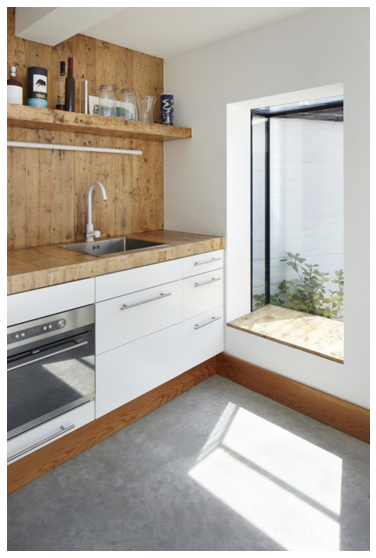

In [ ]:
df_test = df.loc[df['oven'] == True].reset_index()

random_filepath = df_test['filepath'][np.random.randint(0, len(df_test))]

showIMG(random_filepath)

https://github.com/CarterWoolsey/woodentify
https://github.com/amankharwal/Website-data/blob/master/colors.csv

# Color wheel

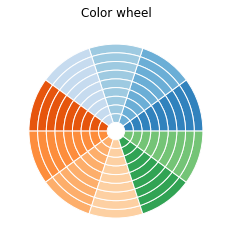

In [ ]:
fig, ax = plt.subplots()

size = 0.1
vals = np.array([[1,1] for a in range(0,10)])

color_list = [
              [[0,0,0],[70,70,70],[125,125,125]],
              [[65,36,20],[116,77,36],[166,124,82]],
              [[110,182,80],[192,212,65],[249,237,37]],
              [[0,104,55],[0,166,82],[35,181,116]],
              [[41,170,227],[86,185,224],[3,169,157]],
              [[147,43,142],[38,33,97],[16,114,187]],
              [[157,31,95],[237,37,123],[240,120,147]],
              [[194,39,45],[240,93,39],[251,176,59]],
              [[170,39,45],[231,111,51],[255,255,255]],

             ]

# cmap = plt.get_cmap("tab20c")
# outer_colors = cmap(np.arange(10))
# inner_colors = cmap(np.arange(10))



for n in range(0,9):
  ax.pie(
      vals.sum(axis=1),
      radius=1-n*size,
      colors=outer_colors,
      wedgeprops=dict(width=size, edgecolor='w')
      )

# ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

# ax.pie(vals.sum(axis=1), radius=1-size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

# ax.pie(vals.sum(axis=1), radius=1-2*size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect='equal', title='Color wheel')
plt.show()

In [ ]:
inner_colors

array([[0.19215686, 0.50980392, 0.74117647, 1.        ],
       [0.41960784, 0.68235294, 0.83921569, 1.        ],
       [0.61960784, 0.79215686, 0.88235294, 1.        ],
       [0.77647059, 0.85882353, 0.9372549 , 1.        ],
       [0.90196078, 0.33333333, 0.05098039, 1.        ],
       [0.99215686, 0.55294118, 0.23529412, 1.        ],
       [0.99215686, 0.68235294, 0.41960784, 1.        ],
       [0.99215686, 0.81568627, 0.63529412, 1.        ],
       [0.19215686, 0.63921569, 0.32941176, 1.        ],
       [0.45490196, 0.76862745, 0.4627451 , 1.        ]])